## Дом на Блюхера, Калининский район

In [1]:
import os
import networkx as nx
import osmnx as ox
import geopandas as gpd

In [2]:
ox_crs = 4326
local_crs = 32636
example_data_path = './data'

city_geometry = gpd.read_file(os.path.join(example_data_path, "etalon_kalininsky.geojson")).to_crs(ox_crs)

In [3]:
from masterplan_tools.preprocessing import GraphGenerator
intermodal_graph = GraphGenerator(city_geometry=city_geometry, local_crs=local_crs).get_graph()

In [4]:
blocks = gpd.read_parquet(os.path.join(example_data_path, "etalon_blocks.parquet")).to_crs(local_crs)
blocks = blocks.sjoin(city_geometry.to_crs(local_crs))

In [5]:
from masterplan_tools.preprocessing import DataGetter, AggregateParameters
dg = DataGetter(blocks=blocks)

In [6]:
accessibility_matrix = dg.get_accessibility_matrix(intermodal_graph)

In [7]:
import math

buildings = gpd.read_file(os.path.join(example_data_path, "etalon_buildings_kalininsky.geojson")).to_crs(local_crs)
greenings = gpd.read_parquet(os.path.join(example_data_path, "greenings.parquet")).rename_geometry('geometry').to_crs(local_crs)
parkings = gpd.read_parquet(os.path.join(example_data_path, "parkings.parquet")).rename_geometry('geometry').to_crs(local_crs)

buildings.drop(labels=['name', 'address', 'municipality', 'ukname'], axis=1, inplace=True)
buildings['living_area_pyatno'] = 0
buildings['total_area'] = 0
buildings['storeys_count'] = 0
buildings['population_balanced'] = buildings['population_balanced'].fillna(0).apply(math.ceil)
buildings['is_living'] = buildings['population_balanced']>0

aggr_params = AggregateParameters(
  buildings=buildings,
  greenings=greenings,
  parkings=parkings
)
aggregated_blocks = dg.aggregate_blocks_info(aggr_params)

Restoring living area:   0%|          | 0/1622 [00:00<?, ?it/s]

Restoring living area squash:   0%|          | 0/1622 [00:00<?, ?it/s]

In [8]:
from masterplan_tools.models import City

city_model = City(accessibility_matrix.df, aggregated_blocks.to_gdf())

In [9]:
schools = gpd.read_file(os.path.join(example_data_path, "etalon_schools.geojson")).to_crs(local_crs)
kindergartens = gpd.read_file(os.path.join(example_data_path, "etalon_kindergartens.geojson")).to_crs(local_crs)

city_model.update_service_type_layer(city_model['schools'], schools)
city_model.update_service_type_layer(city_model['kindergartens'], kindergartens)

In [10]:
from masterplan_tools.method.provision import Provision

selected_block = city_model[73]
provision = Provision(city_model=city_model)

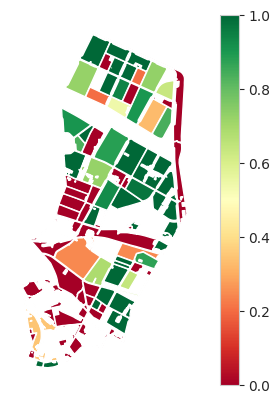

In [18]:
prov_before = provision.calculate_provision(city_model['kindergartens'])
Provision.plot(prov_before)

In [20]:
import pandas as pd

update = {
  selected_block.id : {
    'population': 2333,
    'kindergartens': 160,
    'schools': 0
  }
} 
update_df = pd.DataFrame.from_dict(update, orient='index')

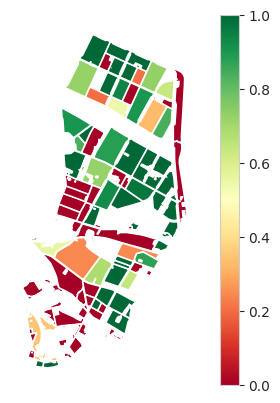

In [21]:
prov_after = provision.calculate_provision(city_model['kindergartens'], update_df)
Provision.plot(prov_after)

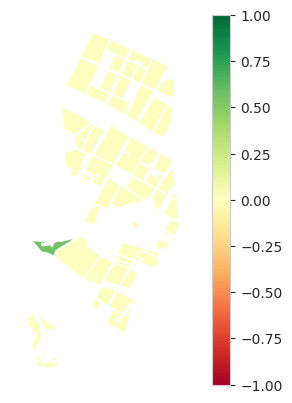

In [22]:
Provision.plot_delta(prov_before, prov_after)